# Hey

To run this notebook, you will need to install ``bm3d``.

Please uncomment the cell below.

In [1]:
# !pip install bm3d==3.0.9

In [2]:
"""
    Copyright (c) 2023 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 15/11/2022

    Code description :
    __________________
    Reconstructs a piecewise constant 2D object using the ROP model and PyProximal package. A PnP prior is used!
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers
import imageio
import bm3d 
import pylops
import pyproximal

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),1),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from functions import PSNR, imresample
from graphics import *

C:\Users\leblanco.OASIS\AppData\Local\Temp\ipykernel_26432\1501048346.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  f = imageio.imread(os.path.join(updir(os.getcwd(),1), "images/"+imname)) / 255.


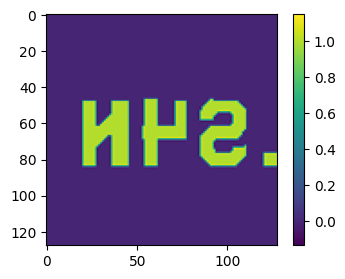

In [3]:
"Load an image"
imname = "f_ds.png" # cameraman.png, usaf.jpg
f = imageio.imread(os.path.join(updir(os.getcwd(),1), "images/"+imname)) / 255.
f = imresample(f, (128,128))
N = f.shape[0]

plt.figure(figsize=(4,3))
plt.imshow(f)
plt.colorbar()
plt.show()

Solve
\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \lambda \lVert \boldsymbol u \rVert_{\text{TV}}
\end{equation*}

using Forward-Backward algorithm:

\begin{equation*}
    \boldsymbol x^{(k+1)} = \text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \left( \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right)
\end{equation*}

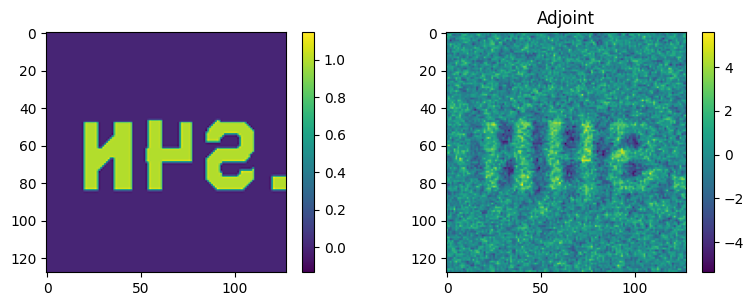

In [4]:
M = 2000
Q = 120
maxit=150

"Parameters"
D = 176e-6 # MCF diameter
lamb = 1050e-9 # Laser wavelength
z = 500e-6 # Imaging depth
L = 300e-6 # Camera aperture width
Delta = L/N # Camera resolution [m/pixel]
lambz = lamb*z

"Cores positions"
pqx,pqy = LE_cores(D,Q)
Om_x = np.subtract.outer(pqx, pqx)
Om_y = np.subtract.outer(pqy, pqy)
Om_x2 = np.round(N*Om_x*Delta/lambz).astype(int)
Om_y2 = np.round(N*Om_y*Delta/lambz).astype(int)

"Apply FOV window"
x = np.linspace(-L/2,L/2,N)
xx,yy = np.meshgrid(x,x)
sig=L/8
# sqrtw = np.sqrt(np.exp(-(xx**2+yy**2)/(2*sig**2)))
sqrtw = np.ones(f.shape)
w=sqrtw**2

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core

"pyproximal"
Fop = pylops.signalprocessing.FFT2D(dims=f.shape)
Sop = pylops.S_Om(f.shape, Om_x2, Om_y2)
Rop = pylops.ROP(a_ij, diagless=True)
Top = Rop*Sop*Fop

y = Top*f.reshape(-1)
adjoint = np.real((Top.T*y).reshape(f.shape))

fig = plt.figure(figsize=(8,3))
axs = [fig.add_axes([0.05,0.1,0.4,0.8]), fig.add_axes([0.55,0.1,0.4,0.8])]
im0 = axs[0].imshow(w*f)
im1 = axs[1].imshow(adjoint)
axs[1].set_title('Adjoint')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
plt.show()
plt.show()

Observe a reconstruction here below. Note that no debiasing trick was applied here so the recovery algorithm is totally blind of the mean of the image. Consequently it will recover a zero-mean object.

In [5]:
nu_rop = eval_nu(np.random.randn(N**2), Top, Top.T, nb_iter=50)*1.01

l2 = pyproximal.L2(Op=Top, b=y, sigma=0.5)

# BM3D denoiser
sigma = 1e0
tau = 1/nu_rop
denoiser = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma * tau,
                                    stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
"Solve"
tau=0.5
x0 = np.zeros(N**2)

def callback(x, xtrue, errhist):
    errhist.append(np.linalg.norm(x - xtrue))
errhist = []
xpnp = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, f.shape,
                                               tau=tau, x0=x0,
                                               niter=30, show=False,
                                               callback=lambda xx: callback(xx, f.ravel(),
                                                                            errhist))[0]
                                            
show_rec2D(f, np.real(xpnp).reshape((N,N)), objective=None, linewidth=1.2)

plt.figure(figsize=(12, 3))
plt.plot(errhist, 'k', lw=2)
plt.title("Error norm")
plt.tight_layout()

ValueError: operands could not be broadcast together with shapes (16384,) (128,128) 